In [4]:
pip install torchbnn

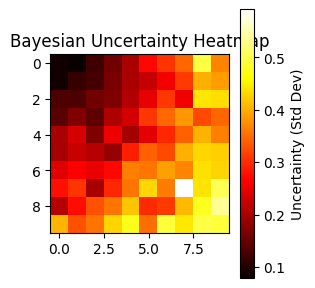

Episode 0: Steps=278, Best=278


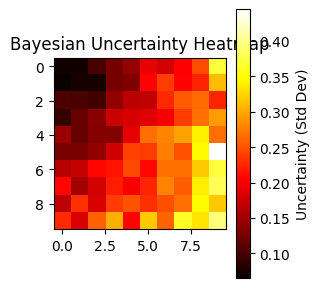

Episode 20: Steps=28, Best=28


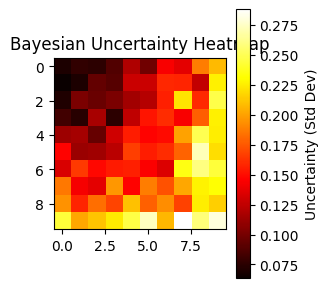

Episode 40: Steps=51, Best=21
Early stopping at episode 58 (no improvement for 20 episodes)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchbnn as bnn

class Maze:
    def __init__(self, size=10):
        self.size = size
        self.grid = np.zeros((size, size))
        self.goal = (size-1, size-1)  # Bottom-right corner
        self.reset()

    def reset(self):
        self.agent_pos = (0, 0)  # Start at top-left
        return self.agent_pos

    def step(self, action):
        """Actions: 0=up, 1=right, 2=down, 3=left"""
        x, y = self.agent_pos
        if action == 0 and x > 0:           x -= 1
        elif action == 1 and y < self.size-1: y += 1
        elif action == 2 and x < self.size-1: x += 1
        elif action == 3 and y > 0:           y -= 1

        self.agent_pos = (x, y)
        done = (self.agent_pos == self.goal)
        reward = 1 if done else -0.01  # Small penalty for each step
        return self.agent_pos, reward, done

    def render(self):
        # plt.imshow(self.grid, cmap='binary')
        plt.plot(self.agent_pos[1], self.agent_pos[0], 'ro')  # Agent
        plt.plot(self.goal[1], self.goal[0], 'g*')  # Goal
        plt.title("Maze Navigation (Red=Agent, Green=Goal)")
        plt.show()





class BayesianDQN(torch.nn.Module):
    def __init__(self, state_dim=2, action_dim=4):
        super().__init__()
        # Bayesian layers (uncertainty-aware)
        self.fc1 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=state_dim, out_features=32)
        self.fc2 = bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=32, out_features=action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)


def train_bayesian_dqn(maze, episodes=500, early_stop=True):
    model = BayesianDQN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = bnn.BKLLoss(reduction='mean', last_layer_only=False)

    best_steps = float('inf')
    patience = 20  # Number of episodes to wait without improvement
    no_improve = 0

    for ep in range(episodes):
        state = maze.reset()
        done = False
        steps = 0

        while not done:
            # Convert state to tensor
            state_tensor = torch.FloatTensor(state)

            # Bayesian forward pass (samples weights from distribution)
            q_values = model(state_tensor)
            action = torch.argmax(q_values).item()

            # Take action
            next_state, reward, done = maze.step(action)

            # Compute loss (MSE + Bayesian KL divergence)
            target = reward + 0.99 * torch.max(model(torch.FloatTensor(next_state)))
            loss = torch.nn.MSELoss()(q_values[action], target) + criterion(model)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Increment the number of steps taken
            steps += 1

            state = next_state

        # Early stopping logic
        if early_stop:
            if steps < best_steps:
                best_steps = steps
                no_improve = 0
            else:
                no_improve += 1

            if no_improve >= patience:
                print(f"Early stopping at episode {ep} (no improvement for {patience} episodes)")
                break

        # Visualization and logging
        if ep % 20 == 0:
            visualize_uncertainty(model, maze)
            print(f"Episode {ep}: Steps={steps}, Best={best_steps}")

def visualize_uncertainty(model, maze):
    """Generate a heatmap of model uncertainty across the maze"""
    uncertainty_map = np.zeros((maze.size, maze.size))

    for x in range(maze.size):
        for y in range(maze.size):
            state = torch.FloatTensor([x, y])
            # Sample multiple forward passes (Bayesian uncertainty)
            q_samples = [model(state).detach().numpy() for _ in range(10)]
            std_dev = np.std(q_samples, axis=0).mean()  # Higher = more uncertain
            uncertainty_map[x, y] = std_dev

    # maze.a()

    plt.figure(figsize=(3,3))
    plt.imshow(uncertainty_map, cmap='hot')
    # The two following lines plot the position of the Agent and the Goal by the time the Agent is done solving the maze
    # Not a particularly informative visual, and thus is commented out
    # plt.plot(maze.agent_pos[1], maze.agent_pos[0], 'ro')  # Agent
    # plt.plot(maze.goal[1], maze.goal[0], 'g*')  # Goal
    plt.colorbar(label='Uncertainty (Std Dev)')
    plt.title("Bayesian Uncertainty Heatmap")

    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    maze = Maze(size=10)
    train_bayesian_dqn(maze)